In [9]:
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
from torchsummary import summary
from safetensors.torch import save_model, load_model
import matplotlib.pyplot as plt
import cv2

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale()
])

In [4]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transforms
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=data_transforms
)

In [5]:
batch_size = 16

# put custom dataset to dataloader
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [6]:
# test if data can be inserted into dataloader
x, y = next(iter(train_dl))
x.shape

torch.Size([16, 1, 28, 28])

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
        )

        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)

        return latent, reconstruction
    
model = AutoEncoder().to(device)
load_model(model, "ae.safetensors")
summary(model, (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]         100,480
              ReLU-2               [-1, 1, 128]               0
            Linear-3                [-1, 1, 32]           4,128
              ReLU-4                [-1, 1, 32]               0
            Linear-5                [-1, 1, 16]             528
              ReLU-6                [-1, 1, 16]               0
            Linear-7                 [-1, 1, 8]             136
            Linear-8                [-1, 1, 16]             144
              ReLU-9                [-1, 1, 16]               0
           Linear-10                [-1, 1, 32]             544
             ReLU-11                [-1, 1, 32]               0
           Linear-12               [-1, 1, 128]           4,224
             ReLU-13               [-1, 1, 128]               0
           Linear-14               [-1,

In [8]:
loss_fn = nn.MSELoss() # con: likes to make things blurry
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

In [9]:
torch.manual_seed(42)

epochs = 10

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    
    # TRAINING
    train_loss =  0
    model.train()
    for batch, (X, y) in enumerate(train_dl):

        X, y = X.reshape(-1, 28 * 28).to(device), y.to(device)

        # forward pass
        train_latent, train_reconstructions = model(X)

        # metrics
        loss = loss_fn(train_reconstructions, X)
        train_loss += loss

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # print metrics
    train_loss /= len(train_dl)
    print(f"Train Loss: {train_loss:.4f}")

    
    # TESTING
    test_loss = 0
    model.eval()
    with torch.inference_mode():
        for X, y in test_dl:

            X, y = X.reshape(-1, 28 * 28).to(device), y.to(device)


            # forward pass
            test_latent, test_reconstructions = model(X)

            # metrics
            test_loss += loss_fn(test_reconstructions, X)

        # print metrics
        test_loss /= len(test_dl)
        print(f"Test Loss: {test_loss:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
------
Train Loss: 0.0570


 10%|█         | 1/10 [00:34<05:10, 34.50s/it]

Test Loss: 0.0363
Epoch: 1
------
Train Loss: 0.0341


 20%|██        | 2/10 [01:07<04:29, 33.68s/it]

Test Loss: 0.0316
Epoch: 2
------
Train Loss: 0.0298


 30%|███       | 3/10 [01:42<03:58, 34.14s/it]

Test Loss: 0.0281
Epoch: 3
------
Train Loss: 0.0271


 40%|████      | 4/10 [02:16<03:24, 34.16s/it]

Test Loss: 0.0261
Epoch: 4
------
Train Loss: 0.0255


 50%|█████     | 5/10 [02:50<02:50, 34.09s/it]

Test Loss: 0.0249
Epoch: 5
------
Train Loss: 0.0244


 60%|██████    | 6/10 [03:24<02:15, 33.98s/it]

Test Loss: 0.0240
Epoch: 6
------
Train Loss: 0.0236


 70%|███████   | 7/10 [03:58<01:42, 34.09s/it]

Test Loss: 0.0233
Epoch: 7
------
Train Loss: 0.0230


 80%|████████  | 8/10 [04:33<01:08, 34.29s/it]

Test Loss: 0.0227
Epoch: 8
------
Train Loss: 0.0224


 90%|█████████ | 9/10 [05:05<00:33, 33.50s/it]

Test Loss: 0.0221
Epoch: 9
------
Train Loss: 0.0217


100%|██████████| 10/10 [05:40<00:00, 34.01s/it]

Test Loss: 0.0214


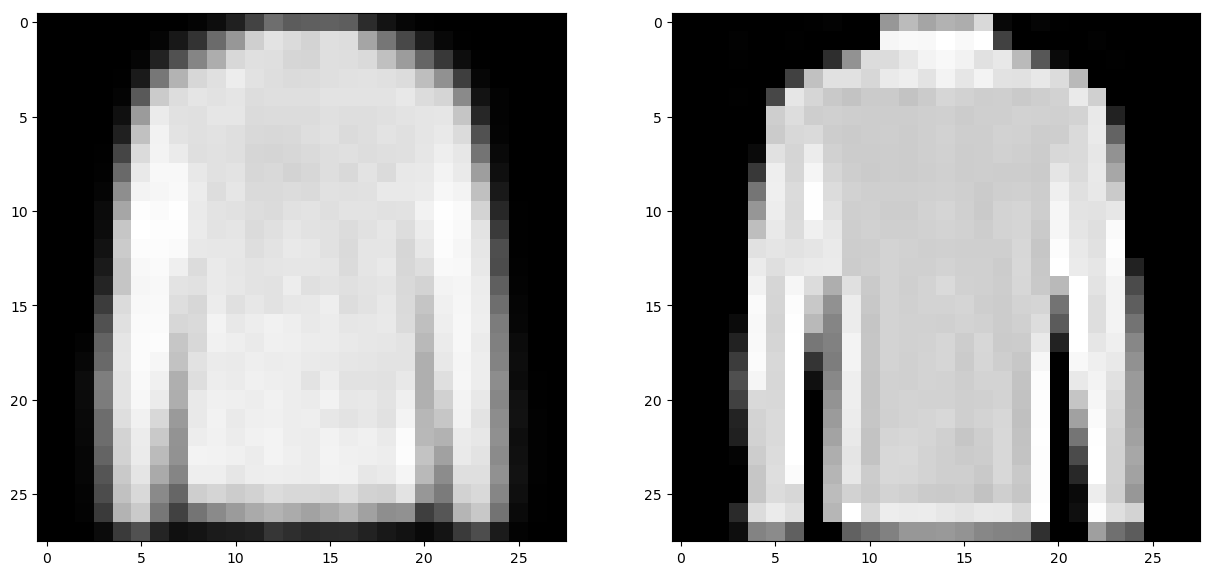

In [23]:
X, y = next(iter(train_dl))
X, y = X[0, :, :].reshape(1, 28*28).to(device), y[0].to(device)

sample_latent, sample_reconstruction = model(X)
sample_reconstruction = sample_reconstruction.reshape(28, 28).detach().cpu().numpy()

X_img = X.reshape(28, 28).detach().cpu().numpy()

plt.figure(figsize=(15, 8))

plt.subplot(121)
plt.imshow(sample_reconstruction, cmap="gray")

plt.subplot(122)
plt.imshow(X_img, cmap="gray")

In [11]:
save_model(model, "ae.safetensors")